In [ ]:
!pip install -q accelerate ultralytics torch diffusers transformers comet_ml

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Set up Comet

In [ ]:
import  comet_ml

comet_ml.init(anonymous=True, project_name="Diffusion Prompting and Image generation")

In [ ]:
# Create the Comet Experiment for logging
exp = comet_ml.Experiment()

### Load images

>Image Ref: the image has been collected from a movie scene Dreamer(2005)

(825, 412)


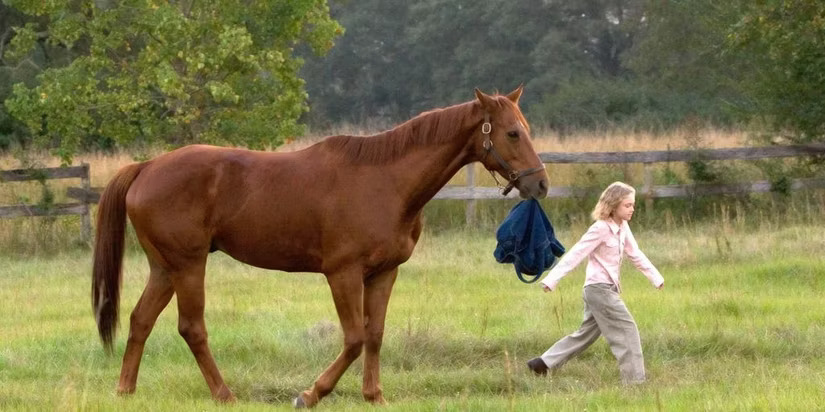

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image

image= Image.open('dreamer_horse_girl.jpg')

print(image.size)
image


### Generating masks

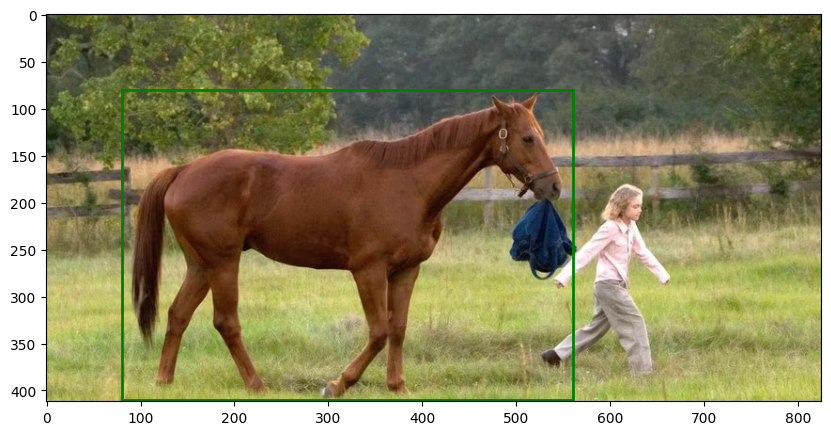

In [ ]:
from matplotlib import pyplot as plt
from utils import show_boxes_on_image , box_prompt, show_masks_on_image

# [xmin, ymin, xmax, ymax]
input_boxes = [80, 80, 560, 410]

# Visualize the bounding box defined with the coordinates above
show_boxes_on_image(image, [input_boxes])

In [ ]:
import shutil
shutil.copy('/content/drive/MyDrive/FastSAM.pt', '/content')

'/content/FastSAM.pt'

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from ultralytics import YOLO
sam_model = YOLO('./FastSAM.pt')


0: 512x1024 22 objects, 201.8ms
Speed: 22.2ms preprocess, 201.8ms inference, 2918.1ms postprocess per image at shape (1, 3, 512, 1024)


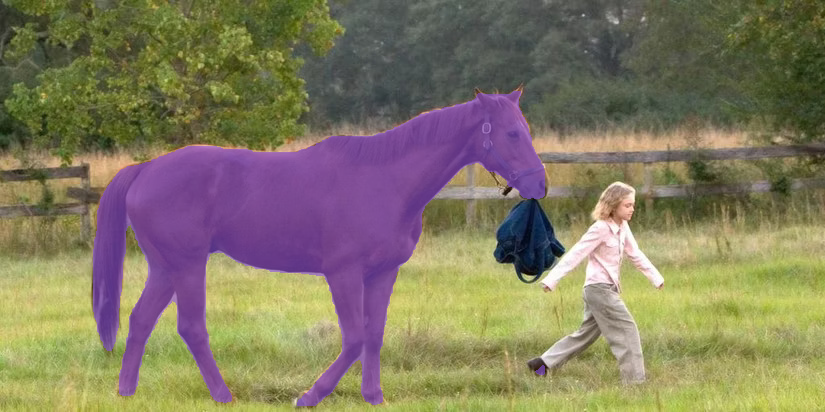

In [ ]:
results = sam_model(image, device=device, retina_masks=True)

#Generate the masks
masks = results[0].masks.data

# Convert to True/False booleans
masks = masks > 0

masks, _ = box_prompt(masks, input_boxes)

# Visualize the masks
show_masks_on_image(image, [masks])

In [ ]:
masks

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

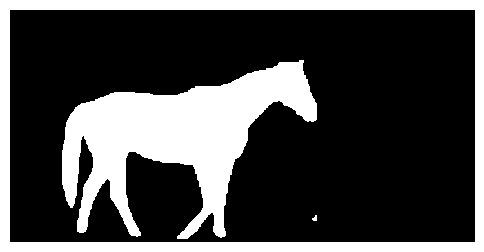

In [ ]:
import numpy as np

# Visualize the mask using plt.imshow
plt.figure(figsize=(6, 6))
plt.imshow(masks, cmap='gray', interpolation='none')
plt.axis('off')  # Turn off the axis

# Save the mask image
plt.savefig('horse_binary_mask.png', bbox_inches='tight', pad_inches=0)

plt.show()

In [ ]:
image=Image.open("/content/dreamer_horse_girl.jpg").resize((256, 256))
image_mask=Image.open("/content/horse_binary_mask.png").resize((256, 256))

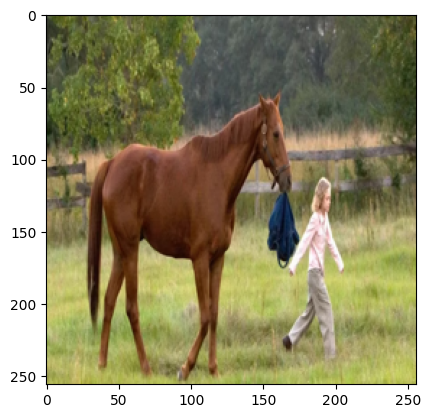

In [ ]:
import matplotlib.pyplot as plt

# Print the image
plt.imshow(image)

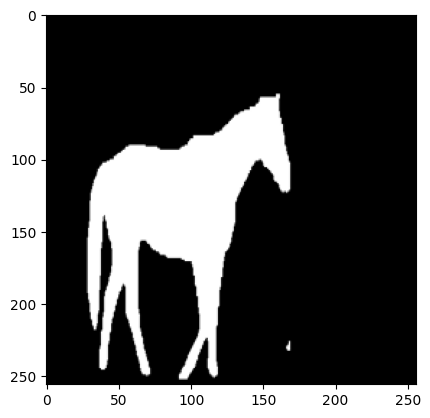

In [ ]:
# Print the mask
plt.imshow(image_mask)

### Import and prepare the model

* Initialize the Stable Diffusion inpainting pipeline.


bfloat16 improves efficiency of the training, uses less memory during training, saves space while maintaining the same accuracy level.

In [ ]:
from diffusers import StableDiffusionInpaintPipeline

sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting", #huggingface
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.bfloat16,
    low_cpu_mem_usage=False if torch.cuda.is_available() else True,
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# Set the value of seed manually for reproducibility of the results
seed = 66733
generator = torch.Generator(device).manual_seed(seed)

In [ ]:
prompt = "a realistic green dragon"

In [ ]:
exp = comet_ml.Experiment()

output = sd_pipe(
  image=image,
  mask_image=image_mask,
  prompt=prompt,
  generator=generator,
  num_inference_steps=3,
)

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : fresh_macaw_7814
COMET INFO:     url                   : https://www.comet.com/proposed-pavilion-5984/diffusion-prompting-and-image-generation/9d4af116de02422ea342d22105cea26c
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and co

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
generated_image = output.images[0]

exp.log_image(
    generated_image,
    name=f"{prompt}",
    metadata={
        "prompt": prompt,
        "seed": seed,
        "num_inference_steps": 3
    }
)

exp.end()

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : famous_peafowl_539
COMET INFO:     url                   : https://www.comet.com/proposed-pavilion-5984/diffusion-prompting-and-image-generation/c02a7b85196c40d68df2508f01aea045
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     images              : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 


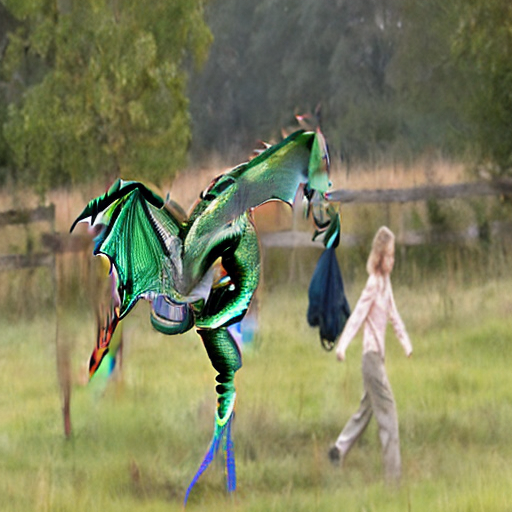

In [ ]:
generated_image

### Note:
- I'll now explore different hyperparameters.

* Set up a different 'number of inference steps'.

In [ ]:
exp = comet_ml.Experiment()

prompt = "a realistic green dragon with four legs" #changing the prompt a bit

exp.log_parameters({
    "seed": seed,
    "num_inference_steps": 300
})

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : recent_plan_7082
COMET INFO:     url                   : https://www.comet.com/proposed-pavilion-5984/diffusion-prompting-and-image-generation/3c26c00d64714787abe46843c795cd8a
COMET INFO:   Parameters:
COMET INFO:     num_inference_steps : 300
COMET INFO:     seed                : 66733
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: As you are runni

In [ ]:
output = sd_pipe(
  image=image,
  mask_image=image_mask,
  prompt=prompt,
  generator=generator,
  num_inference_steps=300,
)

generated_image = output.images[0]

exp.log_image(
    generated_image,
    name=f"{prompt}",
    metadata={
        "prompt": prompt,
        "seed": seed,
        "num_inference_steps": 300
    }
)

exp.end()

  0%|          | 0/300 [00:00<?, ?it/s]

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : expensive_minivan_9418
COMET INFO:     url                   : https://www.comet.com/proposed-pavilion-5984/diffusion-prompting-and-image-generation/20ffe4c29844495eb00018b6110e9edd
COMET INFO:   Parameters:
COMET INFO:     num_inference_steps : 300
COMET INFO:     seed                : 66733
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     images              : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 

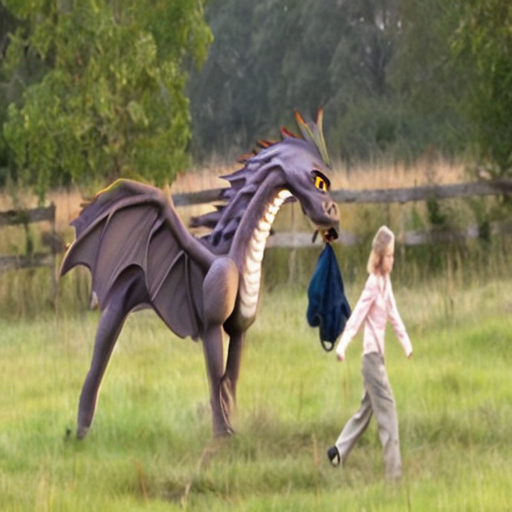

In [ ]:
generated_image

#### Set up the different 'Guidance Scale' values.


- Passing the guidance_scale to this pipeline

In [ ]:
import numpy as np
guidance_scale_values = [x for x in np.arange(0, 21, 10)]

In [ ]:
exp = comet_ml.Experiment()

prompt = "a realistic green dragon with four legs"

num_inference_steps = 300 #if torch.cuda.is_available() else 10

exp.log_parameters({
    "seed": seed,
})

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/proposed-pavilion-5984/diffusion-prompting-and-image-generation/ddef67f63d36448aad6971e98439d0fd



In [ ]:
for guidance_scale in guidance_scale_values:

    output = sd_pipe(
      image=image,
      mask_image=image_mask,
      prompt=prompt,
      generator=generator,
      num_inference_steps=num_inference_steps,
      guidance_scale=guidance_scale
    )

    generated_image = output.images[0]

    exp.log_image(
        generated_image,
        name=f"{prompt}",
        metadata={
            "prompt": prompt,
            "seed": seed,
            "num_inference_steps": num_inference_steps,
            "guidance_scale": guidance_scale
        }
    )

exp.end()

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : motionless_hip_2389
COMET INFO:     url                   : https://www.comet.com/proposed-pavilion-5984/diffusion-prompting-and-image-generation/ddef67f63d36448aad6971e98439d0fd
COMET INFO:   Parameters:
COMET INFO:     seed : 66733
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     images              : 3
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 


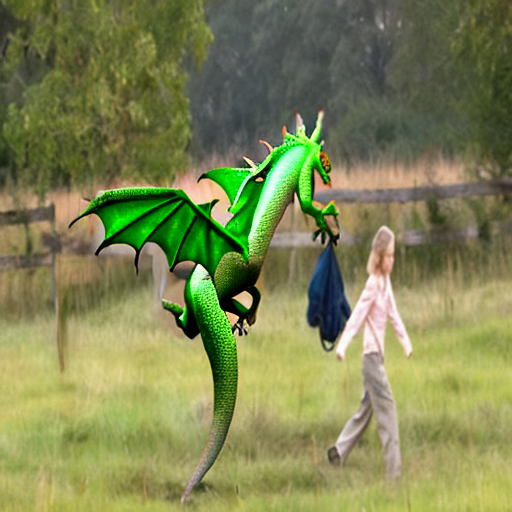

In [ ]:
generated_image

#### Set up another hyperparameter: 'strength'.

- Add the strength hyperparameter
- This code is best run on a GPU.

In [ ]:
strength_values = [x for x in np.arange(0.1, 1.1, 0.2)]

In [ ]:
exp = comet_ml.Experiment()

prompt = "a realistic green dragon with four legs" #changed prompt a bit

num_inference_steps = 200 if torch.cuda.is_available() else 10

exp.log_parameters({
    "seed": seed,
})

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/proposed-pavilion-5984/diffusion-prompting-and-image-generation/d8952e670b824b9e9e601932eb78b1f6



In [ ]:
for strength in strength_values:

    output = sd_pipe(
      image=image,
      mask_image=image_mask,
      prompt=prompt,
      generator=generator,
      num_inference_steps=num_inference_steps,
      strength=strength
    )

    generated_image = output.images[0]

    exp.log_image(
        generated_image,
        name=f"{prompt}",
        metadata={
            "prompt": prompt,
            "seed": seed,
            "num_inference_steps": num_inference_steps,
            "strength": strength
        }
    )

exp.end()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : yummy_badger_8792
COMET INFO:     url                   : https://www.comet.com/proposed-pavilion-5984/diffusion-prompting-and-image-generation/d8952e670b824b9e9e601932eb78b1f6
COMET INFO:   Parameters:
COMET INFO:     seed : 66733
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     images              : 5
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 


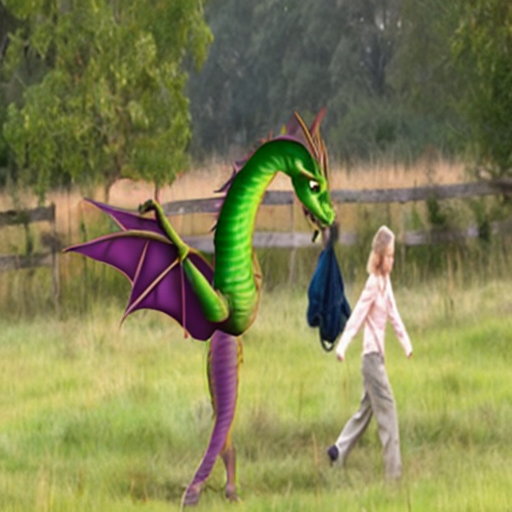

In [ ]:
generated_image

### Try adding a Negative Prompt.
- If you set the negative prompt to "cartoon", this is asking the image generation model to not generate an image that looks like a cartoon.

In [ ]:
exp = comet_ml.Experiment()

prompt = "a realistic green dragon"
negative_prompt = "cartoon"

num_inference_steps = 500 if torch.cuda.is_available() else 10

exp.log_parameters({
    "seed": seed,
})

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/proposed-pavilion-5984/diffusion-prompting-and-image-generation/ea598391586e48abaece42d4031b31c3



In [ ]:
output = sd_pipe(
  image=image,
  mask_image=image_mask,
  prompt=prompt,
  negative_prompt=negative_prompt,
  generator=generator,
  num_inference_steps=num_inference_steps,
  guidance_scale=10
)

generated_image = output.images[0]

exp.log_image(
    generated_image,
    name=f"{prompt}",
    metadata={
        "prompt": prompt,
        "seed": seed,
        "num_inference_steps": num_inference_steps,
        "guidance_scale": 10
    }
)

exp.end()

  0%|          | 0/500 [00:00<?, ?it/s]

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : popular_spore_9792
COMET INFO:     url                   : https://www.comet.com/proposed-pavilion-5984/diffusion-prompting-and-image-generation/ea598391586e48abaece42d4031b31c3
COMET INFO:   Parameters:
COMET INFO:     seed : 66733
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     images              : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 


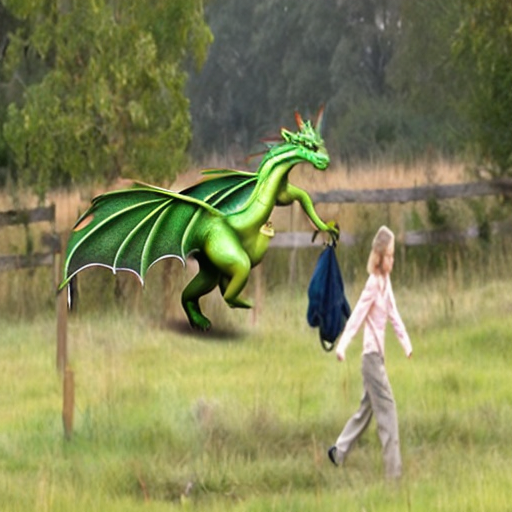

In [ ]:
generated_image